In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#del df_comp['spx']
#del df_comp['dax']
#del df_comp['ftse']
#del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Retornos

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

In [8]:
import statsmodels.tsa.stattools as sts 
sts.adfuller(df.returns[1:])

(-12.770265719497296,
 7.798058336036148e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

## ARIMA(1,1,1)

In [13]:
# ARIMA SE HACE SOBRE SERIES NOES ETACIONARIAS SINO SERIA COMPLEJIZARLO INUTILMENTE - EN ESE CASO UN ARMA

model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

# la cte. no es significativamene diferente de 0, el p-valor es grande, podemos considerar la cte. 0
# este era el caso de los retornos  - que la cte. es 0, porque los retornos ya estan haciendo una integracion
# esparecido al ARMA(1,1) de retornos ( no a los precios que la cte. si es significativmaente distinta de 0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Thu, 13 Apr 2023   AIC                          55215.333
Time:                        17:52:05   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

## Residuals of the ARIMA(1,1,1)

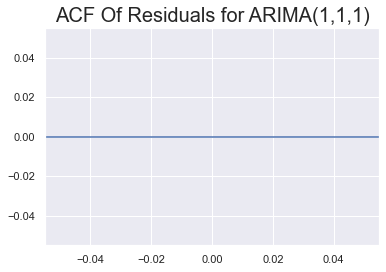

In [14]:
# AQUI NO SE PUEDE CALCULAR - SE DEBE A QUE HAY UN VALOR FALTANTE AL HABER HABIDO UNA INTEGRACION
# LO MEJOR ES NO CONSIDERAR LA PRIMERA FILA

df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

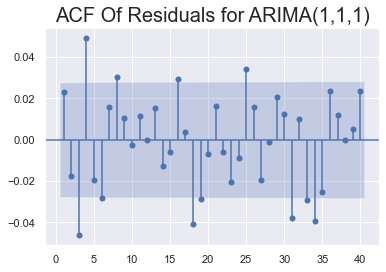

In [11]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

# tercer y cuarto residuo  son significativos - incorporarlos podria mejorar el rendimiento del modelo
# asi que merece la pena complejizar el modelo a partir del ARIMA simple
# nos centraremos en (p,1,q)
# vamos a incluir los retrasos 3o y 4o
# solo cogemos los que todos sus valores son significativos  - el resto no lo hemos considerado al no ser significativos (hechos a parte)
# todas las combinaciones hasta 4


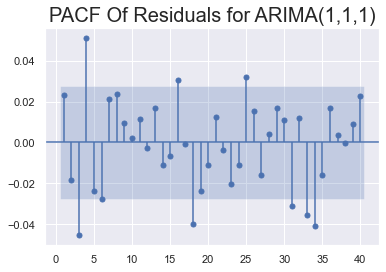

In [12]:
sgt.plot_pacf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("PACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

## Higher-Lag ARIMA Models

In [23]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=1)
#results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()

model_ar_3_i_1_ma_3 = ARIMA(df.market_value, order=(3,1,3))
results_ar_3_i_1_ma_3= model_ar_3_i_1_ma_1.fit()

model_ar_4_i_1_ma_1 = ARIMA(df.market_value, order=(4,1,1))
results_ar_4_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_4_i_1_ma_2 = ARIMA(df.market_value, order=(4,1,2))
results_ar_4_i_1_ma_2 = model_ar_3_i_1_ma_1.fit()
model_ar_4_i_1_ma_3 = ARIMA(df.market_value, order=(4,1,3))
results_ar_4_i_1_ma_3 = model_ar_3_i_1_ma_1.fit()
model_ar_4_i_1_ma_4 = ARIMA(df.market_value, order=(4,1,4))
results_ar_4_i_1_ma_4 = model_ar_3_i_1_ma_1.fit()

In [24]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)


print("ARIMA(3,1,3):  \t LL = ", results_ar_3_i_1_ma_3.llf, "\t AIC = ", results_ar_3_i_1_ma_3.aic)
print("ARIMA(4,1,1):  \t LL = ", results_ar_4_i_1_ma_1.llf, "\t AIC = ", results_ar_4_i_1_ma_1.aic)
print("ARIMA(4,1,2):  \t LL = ", results_ar_4_i_1_ma_2.llf, "\t AIC = ", results_ar_4_i_1_ma_2.aic)
print("ARIMA(4,1,3):  \t LL = ", results_ar_4_i_1_ma_3.llf, "\t AIC = ", results_ar_4_i_1_ma_3.aic)
print("ARIMA(4,1,4):  \t LL = ", results_ar_4_i_1_ma_4.llf, "\t AIC = ", results_ar_4_i_1_ma_4.aic)

#el 1,1,3 produce el mayor de verosimilitud  y el menor AIC) - es el mejor hasta ahora


ARIMA(1,1,1):  	 LL =  -27603.6664127652 	 AIC =  55215.3328255304
ARIMA(1,1,2):  	 LL =  -27600.081863117895 	 AIC =  55210.16372623579
ARIMA(1,1,3):  	 LL =  -27590.424032603754 	 AIC =  55192.84806520751
ARIMA(2,1,1):  	 LL =  -27599.807487846567 	 AIC =  55209.61497569313
ARIMA(3,1,1):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099
ARIMA(3,1,2):  	 LL =  -27590.660808972378 	 AIC =  55195.321617944755
ARIMA(3,1,3):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099
ARIMA(4,1,1):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099
ARIMA(4,1,2):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099
ARIMA(4,1,3):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099
ARIMA(4,1,4):  	 LL =  -27592.05537170495 	 AIC =  55196.1107434099


In [25]:
results_ar_1_i_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -27590.424
Method:                       css-mle   S.D. of innovations             58.978
Date:                Wed, 11 May 2022   AIC                          55192.848
Time:                        21:26:58   BIC                          55231.975
Sample:                    01-10-1994   HQIC                         55206.559
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5653      0.723      0.782      0.434      -0.851       1.982
ar.L1.D.market_value    -0.3585      0.125     -2.878      0.004      -0.603      -0.114
ma.L1.D.market_value     0.3386      0.124      2.730      0.006       0.096       0.582
ma.L2.D.market_value    -0.0590      0.015     -3.932      0.000      -0.088      -0.030
ma.L3.D.market_value    -0.1002      0.015     -6.866      0.000      -0.129      -0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7896           +0.0000j            2.7896            0.5000
MA.1           -1.5201           -1.3272j            2.0180           -0.3858
MA.2           -1.5201           +1.3272j            2.0180            0.3858
MA.3            2.4511           -0.0000j            2.4511           -0.0000
-----------------------------------------------------------------------------
"""

In [17]:
# estos estan aninados asi que miramos si supera al 111 y al 112
# 1 parametro de diferencia - grado del ibertad, por eso es el valor por defecto

print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_2, results_ar_1_i_1_ma_3)))


LLR test p-value = 0.0


In [18]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_1, results_ar_1_i_1_ma_3, DF = 2)))


LLR test p-value = 0.0


In [27]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_3, results_ar_3_i_1_ma_3, DF = 2)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_3, results_ar_4_i_1_ma_4, DF = 4)))


LLR test p-value = 1.0

LLR test p-value = 1.0


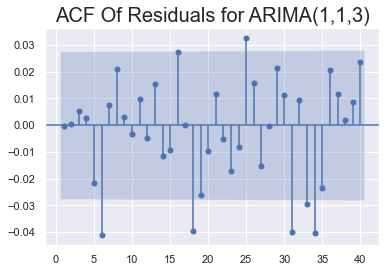

In [28]:
# ecaminamos los residuos de 1,1,3 para ver si vale o no ...

df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

# aqui los retrasos 1,2,3,4,5 ya no son significativos comorado con (1,1,1)
# el secto sigue siendo muy significativo

In [32]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
model_ar_5_i_1_ma_2 = ARIMA(df.market_value, order=(5,1,2))
results_ar_5_i_1_ma_2 = model_ar_5_i_1_ma_2.fit()
model_ar_5_i_1_ma_3 = ARIMA(df.market_value, order=(5,1,3))
results_ar_5_i_1_ma_3 = model_ar_5_i_1_ma_3.fit()
model_ar_5_i_1_ma_4 = ARIMA(df.market_value, order=(5,1,4))
results_ar_5_i_1_ma_4 = model_ar_5_i_1_ma_4.fit()
model_ar_5_i_1_ma_5 = ARIMA(df.market_value, order=(5,1,5))
results_ar_5_i_1_ma_5 = model_ar_5_i_1_ma_5.fit()
#results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit()

In [34]:
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(5,1,2):  \t LL = ", results_ar_5_i_1_ma_2.llf, "\t AIC = ", results_ar_5_i_1_ma_2.aic)
print("ARIMA(5,1,3):  \t LL = ", results_ar_5_i_1_ma_3.llf, "\t AIC = ", results_ar_5_i_1_ma_3.aic)
print("ARIMA(5,1,4):  \t LL = ", results_ar_5_i_1_ma_4.llf, "\t AIC = ", results_ar_5_i_1_ma_4.aic)
print("ARIMA(5,1,5):  \t LL = ", results_ar_5_i_1_ma_5.llf, "\t AIC = ", results_ar_5_i_1_ma_5.aic)


ARIMA(5,1,1):  	 LL =  -27586.511888106175 	 AIC =  55189.02377621235
ARIMA(5,1,2):  	 LL =  -27584.131001543567 	 AIC =  55186.26200308713
ARIMA(5,1,3):  	 LL =  -27583.45795869937 	 AIC =  55186.91591739874
ARIMA(5,1,4):  	 LL =  -27580.95388033568 	 AIC =  55183.90776067136
ARIMA(5,1,5):  	 LL =  -27576.175567759634 	 AIC =  55176.35113551927


In [35]:
results_ar_5_i_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -27576.176
Method:                       css-mle   S.D. of innovations             58.805
Date:                Wed, 11 May 2022   AIC                          55176.351
Time:                        21:38:17   BIC                          55254.605
Sample:                    01-10-1994   HQIC                         55203.772
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5717      0.710      0.805      0.421      -0.820       1.964
ar.L1.D.market_value     1.5235      0.131     11.602      0.000       1.266       1.781
ar.L2.D.market_value    -0.7878      0.245     -3.210      0.001      -1.269      -0.307
ar.L3.D.market_value     0.5719      0.358      1.596      0.111      -0.131       1.274
ar.L4.D.market_value    -0.8654      0.320     -2.702      0.007      -1.493      -0.238
ar.L5.D.market_value     0.3159      0.144      2.201      0.028       0.035       0.597
ma.L1.D.market_value    -1.5459      0.127    -12.158      0.000      -1.795      -1.297
ma.L2.D.market_value     0.7638      0.241      3.175      0.001       0.292       1.235
ma.L3.D.market_value    -0.5771      0.348     -1.661      0.097      -1.258       0.104
ma.L4.D.market_value     0.9715      0.304      3.201      0.001       0.377       1.566
ma.L5.D.market_value    -0.4053      0.135     -3.005      0.003      -0.670      -0.141
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5752           -1.0881j            1.2308           -0.3274
AR.2           -0.5752           +1.0881j            1.2308            0.3274
AR.3            0.9059           -0.4300j            1.0027           -0.0705
AR.4            0.9059           +0.4300j            1.0027            0.0705
AR.5            2.0785           -0.0000j            2.0785           -0.0000
MA.1           -0.5834           -1.0312j            1.1848           -0.3319
MA.2           -0.5834           +1.0312j            1.1848            0.3319
MA.3            0.9068           -0.4266j            1.0021           -0.0700
MA.4            0.9068           +0.4266j            1.0021            0.0700
MA.5            1.7505           -0.0000j            1.7505           -0.0000
-----------------------------------------------------------------------------
"""

In [20]:
# verificamos todos los modelos desde el 4,1,4 que ya consideresmos los que eran significativos
# ahora hay que complejizar hasta el (6,1,6)
#solo el 5,1,1 da coeficientes significativos y nos quedamos con ese

model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit(start_ar_lags=11)
results_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.512
Method:                       css-mle   S.D. of innovations             58.932
Date:                Thu, 31 Mar 2022   AIC                          55189.024
Time:                        12:29:40   BIC                          55241.193
Sample:                    01-10-1994   HQIC                         55207.305
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5663      0.690      0.820      0.412      -0.787       1.920
ar.L1.D.market_value     0.4011      0.159      2.529      0.011       0.090       0.712
ar.L2.D.market_value    -0.0445      0.016     -2.856      0.004      -0.075      -0.014
ar.L3.D.market_value    -0.0543      0.017     -3.163      0.002      -0.088      -0.021
ar.L4.D.market_value     0.0586      0.019      3.069      0.002       0.021       0.096
ar.L5.D.market_value    -0.0581      0.014     -4.118      0.000      -0.086      -0.030
ma.L1.D.market_value    -0.4213      0.158     -2.659      0.008      -0.732      -0.111
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7609           -0.0000j            1.7609           -0.5000
AR.2            1.4633           -0.8605j            1.6975           -0.0846
AR.3            1.4633           +0.8605j            1.6975            0.0846
AR.4           -0.0790           -1.8393j            1.8410           -0.2568
AR.5           -0.0790           +1.8393j            1.8410            0.2568
MA.1            2.3734           +0.0000j            2.3734            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)

# el modelo 5,1,1 tiene mas LL y menos AIC asi que lo mejor y nos quedariamos con este


ARIMA(1,1,3):  	 LL =  -27590.424032603754 	 AIC =  55192.84806520751
ARIMA(5,1,1):  	 LL =  -27586.51188811044 	 AIC =  55189.02377622088


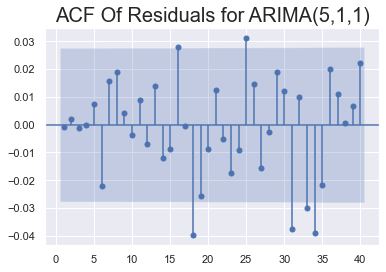

In [22]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,1,1)", size=20)
plt.show()

# ninguno de los primeros 15 tienen coef significativos
# losque son significartivos ya estan muy atras en el pasado y no los consideramos ....
# podiamos incluir hasta 35 retrasos pero queremos que el modelo pueda predecir y por tanto evitar overfittin
# tomar muchos retrasos implicarsa que los parametros del modelo dependan demasiado de los datos de entrenamiento

## comparacion ARMA y ARIMA en estacionario y no estacionario

Necesitamos integracion solo si la serie es no estacionaria
SI una capa de integracion hace la serie estacionaria, cualquier otra lo hace innecesaria (que sea lo menos complejo posible)


In [23]:
df['delta_prices']=df.market_value.diff(1)
#es una diferenciacion de 1 - es lo mismo que una integracion - 1 indica 1 periodo atras

In [24]:
df.head()

,spx,dax,ftse,nikkei,market_value,returns,res_ar_1_i_1_ma_1,res_ar_1_i_1_ma_3,res_ar_5_i_1_ma_1,delta_prices
date,,,,,,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,3445.98,NaN,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44,3440.58,-0.156704,-5.965513,-5.965324,-5.966321,-5.40
1994-01-11,474.13,2228.10,3413.77,18485.25,3413.77,-0.779229,-27.627863,-27.477779,-27.484094,-26.81
1994-01-12,474.17,2182.06,3372.02,18793.88,3372.02,-1.222988,-43.711960,-43.110986,-43.132615,-41.75
1994-01-13,472.47,2142.37,3360.01,18577.26,3360.01,-0.356166,-15.569093,-15.438167,-15.374251,-12.01


In [25]:
# la serie de tiempo inegrada, hacemos un 1,0,1 que es un ARMA

model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1)) #el primer valor no existe
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

# lo comparamos con el ARIMA y vamoes que son iguales - ARMA con diferencias o ARIMA es lo mismo

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Thu, 31 Mar 2022   AIC                          55215.333
Time:                        13:41:03   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.delta_prices     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.delta_prices    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
# NO ES EXATACMENTE LO MISMO PCT_CHANGE Y SUBSTARCT

model_delta_ar_1_i_1_ma_1 = ARIMA(df.returns[1:], order=(1,0,1)) #el primer valor no existe
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Wed, 11 May 2022   AIC                          15841.000
Time:                        22:02:19   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
# vemos que da lo mismo el ARMA sobre estacionario que el ARIMA sobre no estacionario ....

model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 11 May 2022   AIC                          55215.333
Time:                        22:03:04   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

Se puede hacer (1,0,1) sobre no estacionario e inckuso puede converger pero no tendra sentido
y viceversa...

In [22]:
sts.adfuller(df.delta_prices[1:])

# ponesmo hace el dickie-fuller test - el p-valor es 0, delta prices ya es estacionaria y por lo tanto no hace falta integrar mas
# la primera integracion ya asegura la estacionariedad
# no se necesitan capas adicionales de integracion, con 1 vale.

(-32.244093495707475,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54845.96104221891)


## ARIMAX

Vamos a hacer un ARIMAX para FTSE usando como variable exogena el SP500
El modelo es ARIMA igual pero se incluye exog (las variables exogenas - matriz o variable)

In [47]:
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog = df.spx, order=(1,1,1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
results_ar_1_i_1_ma_1_Xspx.summary()

#en este caso se incluye un coeficiende spx - es el beta de la ecuacion
#en este caso no es significativo - SP500 no son significativos en el modelo
#puede que no aporte capacidad predictiva - o porque hace falta todos los precios 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Wed, 11 May 2022   AIC                          55217.112
Time:                        22:07:40   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.537
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6379      2.655     -0.240      0.810      -5.842       4.567
spx                      0.0011      0.002      0.469      0.639      -0.004       0.006
ar.L1.D.market_value     0.7461      0.070     10.596      0.000       0.608       0.884
ma.L1.D.market_value    -0.7921      0.064    -12.297      0.000      -0.918      -0.666
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3403           +0.0000j            1.3403            0.0000
MA.1            1.2625           +0.0000j            1.2625            0.0000
-----------------------------------------------------------------------------
"""

# **ARIMAX: todos los indices bursatiles como exogenos*

In [50]:
dfexog = df[['spx', 'dax', 'nikkei']]
dfexog.head()

# añadira un coeficiente para cada serie de la matriz
# ninguno es significativo
# no aporte capacidad de prediccion

,spx,dax,nikkei
date,,,
1994-01-07,469.90,2224.95,18124.01
1994-01-10,475.27,2225.00,18443.44
1994-01-11,474.13,2228.10,18485.25
1994-01-12,474.17,2182.06,18793.88
1994-01-13,472.47,2142.37,18577.26


In [49]:
modelo_ARIMAX_1_1_1 = ARIMA(df.market_value, exog = dfexog, order=(1,1,1))
resultados_modelo_ARIMAX_1_1_1 = modelo_ARIMAX_1_1_1.fit()
resultados_modelo_ARIMAX_1_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27602.578
Method:                       css-mle   S.D. of innovations             59.121
Date:                Wed, 11 May 2022   AIC                          55219.156
Time:                        22:07:46   BIC                          55264.804
Sample:                    01-10-1994   HQIC                         55235.152
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.7477      4.327     -1.097      0.273     -13.228       3.733
spx                      0.0097      0.006      1.633      0.103      -0.002       0.021
dax                     -0.0014      0.001     -1.419      0.156      -0.003       0.001
nikkei                   0.0001      0.000      0.719      0.472      -0.000       0.000
ar.L1.D.market_value     0.7483      0.071     10.597      0.000       0.610       0.887
ma.L1.D.market_value    -0.7949      0.065    -12.319      0.000      -0.921      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3363           +0.0000j            1.3363            0.0000
MA.1            1.2580           +0.0000j            1.2580            0.0000
-----------------------------------------------------------------------------
"""

El modelo con todas las variables no mejora la calidad del modelo pero si incrementa su complejidad como lo demuestra el resultado de su AIC, que es mayor al modelo que tiene como única variable exógena a SP500.

Y observando la significancia de los coeficientes, podemos afirmar que las variables de precios estadísticamente no aportan una mejor calidad (información) al modelo.